In [ ]:
    # !unzip '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/data/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/data'

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ImageCaptioning

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning


In [ ]:
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from tqdm import tqdm

from nltk.translate.bleu_score import corpus_bleu

# Dataset

In [ ]:
df = pd.read_csv("data/captions.txt")
processed_df = df.copy(deep=True)

In [ ]:
def plot_example(idx):
    """
    Choose idx in range 0 - 8090
    """
    # Plot image
    IMAGES_PATH = 'data/Images'
    image_name = df['image'][idx * 5]
    image = cv2.imread(os.path.join(IMAGES_PATH, image_name))
    print(f"Image's shape: {image.shape}")
    cv2_imshow(image)

    # Print captions
    print('Captions:')
    captions = df['caption'][5 * idx: 5 * idx + 5]
    for idx, values in captions.items():
        print(values)

Image's shape: (429, 500, 3)


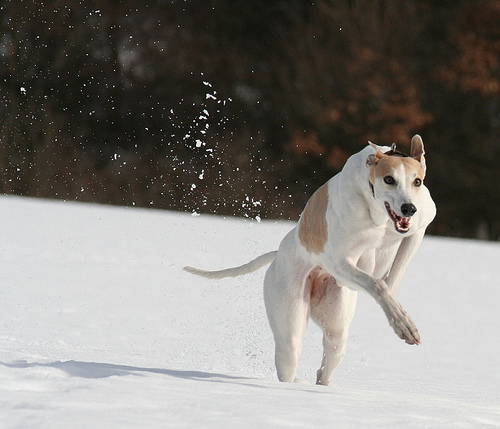

Captions:
A brown and white dog is running through the snow .
A dog is running in the snow
A dog running through snow .
a white and brown dog is running through a snow covered field .
The white and brown dog is running over the surface of the snow .


In [ ]:
plot_example(10)

Image's shape: (500, 333, 3)


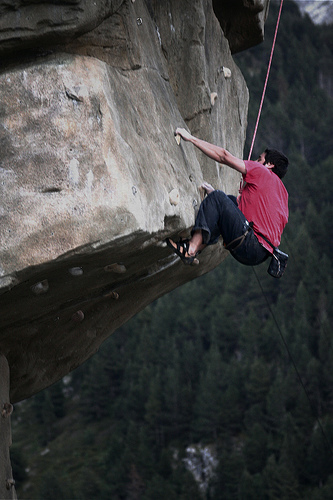

Captions:
A man in a pink shirt climbs a rock face
A man is rock climbing high in the air .
A person in a red shirt climbing up a rock face covered in assist handles .
A rock climber in a red shirt .
A rock climber practices on a rock climbing wall .


In [ ]:
plot_example(8090)

# Preprocessing captions

In [ ]:
def caption_preprocessing(text, remove_digits=True):
    # Remove special character
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)

    # Tokenize
    text = text.split()

    # Convert to lower case
    text = [word.lower() for word in text]

    # Remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]

    # Store as string
    text =  ' '.join(text)

    # Insert 'START_TOKEN' and 'END_TOKEN'
    text = 'START_TOKEN ' + text + ' END_TOKEN'
    return text

print(caption_preprocessing("chao .. ban $ hello980 it's a table.#"))

START_TOKEN chao ban its a table END_TOKEN


In [ ]:
processed_df['caption'] = df['caption'].apply(caption_preprocessing)
processed_df

,image,caption
0,1000268201_693b08cb0e.jpg,START_TOKEN a child in a pink dress is climbin...
1,1000268201_693b08cb0e.jpg,START_TOKEN a girl going into a wooden buildin...
2,1000268201_693b08cb0e.jpg,START_TOKEN a little girl climbing into a wood...
3,1000268201_693b08cb0e.jpg,START_TOKEN a little girl climbing the stairs ...
4,1000268201_693b08cb0e.jpg,START_TOKEN a little girl in a pink dress goin...
...,...,...
40450,997722733_0cb5439472.jpg,START_TOKEN a man in a pink shirt climbs a roc...
40451,997722733_0cb5439472.jpg,START_TOKEN a man is rock climbing high in the...
40452,997722733_0cb5439472.jpg,START_TOKEN a person in a red shirt climbing u...
40453,997722733_0cb5439472.jpg,START_TOKEN a rock climber in a red shirt END_...


In [ ]:
# Count the numbers of word and maximum length

word_counts = {}
MAX_LENGTH = 0

for text in df['caption']:
    caption = text.split()
    MAX_LENGTH = len(caption) if (MAX_LENGTH < len(caption)) else MAX_LENGTH
    for w in caption:
        try:
            word_counts[w] +=1
        except:
            word_counts[w] = 1

print(f'The number of words: {len(word_counts)}')
print(f'Maximum length of a caption: {MAX_LENGTH}')

The number of words: 8777
Maximum length of a caption: 37


In [ ]:
# Filter out word that appears less than 10 times
word_count_threshold = 10
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print(f'After reduce vocabulary:{len(word_counts)} -> {len(vocab)}')

After reduce vocabulary:8777 -> 1952


In [ ]:
# Map word to index and vice versa

i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(f"{w2i['dog']} <-> {i2w[w2i['dog']]}")
print(f"{w2i['cat']} <-> {i2w[w2i['cat']]}")

26 <-> dog
944 <-> cat


# Embedding

In [ ]:
# Download glove embedding

# ! wget https://nlp.stanford.edu/data/glove.6B.zip
# ! mkdir glove
# ! unzip glove.6B.zip -d glove

In [ ]:

embeddings_index = {}

with open('glove/glove.6B.200d.txt', encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        item = line.split()
        word = item[0]
        vector = np.asarray(item[1:], dtype=np.float32)
        embeddings_index[word] = vector


print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
VOCAB_SIZE = len(vocab) + 1
EMBEDDING_DIM = 200
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[idx] = embedding_vector

print(embedding_matrix.shape)

(1953, 200)


# Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [ ]:
pretrained_model = InceptionV3()
feature_extraction_model = Model(pretrained_model.input, pretrained_model.layers[-2].output)
feature_extraction_model.trainable = False

In [ ]:
def build_model():

    # Build model
    input1 = Input(shape=(299, 299, 3))
    fe1 = feature_extraction_model(input1)
    fe2 = Dropout(0.5)(fe1)
    fe3 = Dense(256, activation='relu')(fe2)


    input2 = Input(shape=(MAX_LENGTH,))
    se1 = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True)(input2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe3, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

    model = Model(inputs=[input1, input2], outputs=outputs)
    return model

In [ ]:
model = build_model()

model.layers[3].set_weights([embedding_matrix])
model.layers[3].trainable = False

In [ ]:
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 37)]                 0         []                            
                                                                                                  
 model_6 (Functional)        (None, 2048)                 2180278   ['input_13[0][0]']            
                                                          4                                       
                                                                                                  
 embedding_4 (Embedding)     (None, 37, 200)              390600    ['input_14[0][0]']      

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
EPOCHS = 5
BATCH_SIZE = 16
STEPS = 8091 / BATCH_SIZE
CHECKPOIN_PATH = 'checkpoints/model-{epoch:02d}-{loss:.2f}.h5"'

model.compile(loss=loss,
              optimizer=optimizer)

In [ ]:
def data_generator(df, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for i in range(8091):
        # Read image
        image_name = df['image'][i * 5]
        image = cv2.imread(os.path.join('data/Images', image_name))
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        # Read captions
        captions = df['caption'][5 * i: 5 * i + 5]
        for idx, cap in captions.items():
            # Encode the sequence
            seq = [w2i[word] for word in cap.split(' ') if word in w2i]

            for i in range(1, len(seq)):
                # Split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]

                # Padding input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                # Encode output sequence
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                # Store
                n += 1
                X_image.append(image)
                X_cap.append(in_seq)
                y.append(out_seq)

                if n == batch_size:
                    yield ([np.array(X_image), np.array(X_cap)], np.array(y))
                    X_image, X_cap, y = [], [], []
                    n = 0

In [ ]:

cp_callback = ModelCheckpoint(filepath=CHECKPOIN_PATH,
                              save_best_only=False,
                              save_weights_only=True,
                              verbose=1)

generator = data_generator(df=df,
                           w2i=w2i,
                           max_length=MAX_LENGTH,
                           batch_size=BATCH_SIZE)
model.fit(generator,
          epochs=EPOCHS,
          steps_per_epoch=STEPS,
          verbose=1,
          callbacks=[cp_callback])

Epoch 1/5
506/505 [==============================] - ETA: 0s - loss: 5.0164
Epoch 1: saving model to checkpoints/model-01-5.02.h5"
505/505 [==============================] - 99s 174ms/step - loss: 5.0164
Epoch 2/5
506/505 [==============================] - ETA: 0s - loss: 4.4721
Epoch 2: saving model to checkpoints/model-02-4.47.h5"
505/505 [==============================] - 87s 172ms/step - loss: 4.4721
Epoch 3/5
506/505 [==============================] - ETA: 0s - loss: 4.2933
Epoch 3: saving model to checkpoints/model-03-4.29.h5"
505/505 [==============================] - 85s 169ms/step - loss: 4.2933
Epoch 4/5
506/505 [==============================] - ETA: 0s - loss: 4.2002
Epoch 4: saving model to checkpoints/model-04-4.20.h5"
505/505 [==============================] - 95s 188ms/step - loss: 4.2002
Epoch 5/5
356/505 [====================>.........] - ETA: 27s - loss: 4.0914

KeyboardInterrupt: ignored

In [ ]:
model.save('checkpoints/model-v1.keras')

# Evaluate

In [ ]:
def greedy_search_pred(model, image):
    in_text = 'START_TOKEN'
    for i in range(MAX_LENGTH):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=MAX_LENGTH)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'END_TOKEN':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_pred(image, k_beams):
    pass

In [ ]:
def evaluate_model(model, df, k_beams):
    actual, predicted = list(), list()
    # Step over the whole set
    i = 0
    for i in range(8091):
        image_name = df['image'][i * 5]
        image = cv2.imread(os.path.join('data/Images', image_name))
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        # Store actual captions
        captions = df['caption'][5 * i: 5 * i + 5]
        references = [cap[1].split() for cap in captions.items()]
        actual.append(references)

        # Predict caption
        if k_beams == 1:
            pred = greedy_search_pred(model, image)
        else:
            pass

        # Store predicted caption
        predicted.append(pred.split())

    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)

In [ ]:
loaded_model = load_model('models/model-v1.keras')

In [ ]:
evaluate_model(loaded_model, processed_df, k_beams=1)

KeyboardInterrupt: ignored

# Testing

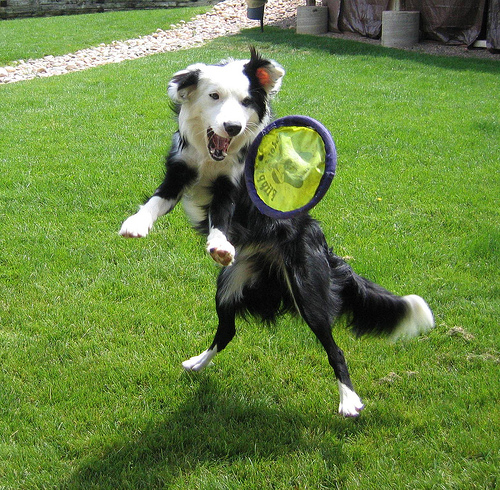

Captions:
A child playing on a rope net .
A little girl climbing on red roping .
A little girl in pink climbs a rope bridge at the park .
A small child grips onto the red ropes at the playground .
The small child climbs on a red ropes on a playground .
Predicted caption: a black and white dog is running through the grass


In [ ]:
IMAGES_PATH = 'data/Images'
image_name = df['image'][50 * 5]
image = cv2.imread(os.path.join(IMAGES_PATH, image_name))

cv2_imshow(image)

image = cv2.resize(image, (299, 299))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
print('Captions:')
captions = df['caption'][5 * 5: 5 * 5 + 5]
for idx, values in captions.items():
    print(values)

predict = greedy_search_pred(loaded_model, image)
print(f'Predicted caption: {predict}')

In [ ]:

image = cv2.imread('istockphoto-1186954832-612x612.jpg')
cv2_imshow(image)

image = cv2.resize(image, (299, 299))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)

predict = greedy_search_pred(image)
print(f'Predicted caption: {predict}')

AttributeError: ignored